### Imports and Declarations

In [4]:
import pyspark
import matplotlib.pyplot as plt
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from functools import reduce

We first initialize the spark session and then import all the data from user reviews. Here is a link to our dataset: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews 

In [5]:
spark = SparkSession.builder.appName("balancing").getOrCreate()

In [6]:
csv_files = glob.glob('./dataset/reviews_*.csv')
dfs = []
for file in csv_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    dfs.append(df)
data = reduce(lambda df1, df2: df1.union(df2), dfs)

Now we ask: are the reviews of different products balanced? ie, do we have enough reviews of every item ? To answer this, let's take a look at the distribution of our data

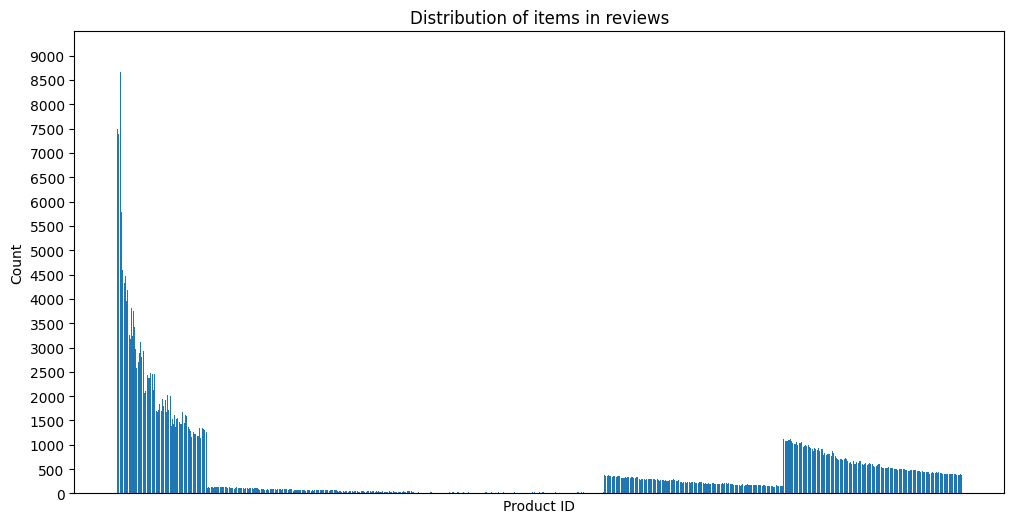

In [7]:
items = data.groupBy('product_id').count()
item_stats = items.filter(col('count').isNotNull() & col('product_id').startswith('P'))
pandas_items = item_stats.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(pandas_items['product_id'], pandas_items['count'])
plt.xticks([])
plt.ylim(0, 9500)
plt.yticks(range(0, 9500, 500))
plt.xlabel('Product ID')
plt.ylabel('Count')
plt.title('Distribution of items in reviews')
plt.show()

As we can see, the set is greatly imbalaced, the  majority of products have between 500 and a little over 1000, with a considerable number having less than 500 and a few over 2000. To account for popularity, or lack thereof, of all items, we will maintain all those datapoints in our datamodel.

Now we ask ourselves this: do we a balanced amount of reviews across users? To answer this, given a number of reviews Y , we will plot Y against the number of users whose total reviews amount to Y.

24/03/21 20:45:54 WARN Executor: Issue communicating with driver in heartbeater]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928

,count
0,4
1,2
2,6
3,7
4,17
...,...
508844,1
508845,1
508846,1
508847,1


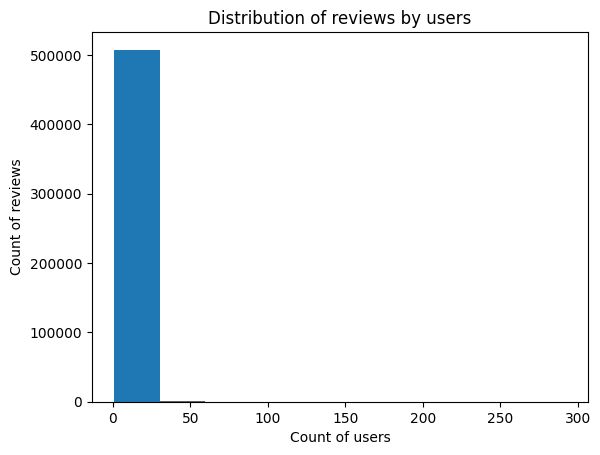

24/03/21 20:46:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [13]:
user_reviews = data.groupBy('author_id').count()
user_reviews = user_reviews.filter(col('author_id').isNotNull()).drop('author_id')
pandas_reviews = user_reviews.toPandas()
pandas_reviews.sort_values(by=['count'])
display(pandas_reviews)
plt.hist(pandas_reviews['count'])
plt.xlabel('Count of users')
plt.ylabel('Count of reviews')
plt.title('Distribution of reviews by users')
plt.show()

We can now start taking a look into our data itself.

We want to disregard items that aren't related to skin type, eye colour or skin tone. Let's look at the item categories we have.

+-----------------+
|primary_category |
+-----------------+
|Tools & Brushes  |
|Skincare         |
| 'All Hair Types'|
|Mini Size        |
|Men              |
|Bath & Body      |
|Fragrance        |
| 'Long-wearing'  |
|Hair             |
|Makeup           |
|Gifts            |
|NULL             |
+-----------------+

+---------------------+
|secondary_category   |
+---------------------+
|Moisturizers         |
|Masks                |
|Wellness             |
|Beauty Accessories   |
| 'Good for: Dryness' |
|Beauty Supplements   |
|Candles & Home Scents|
|Makeup Palettes      |
|Hair Tools           |
|Skincare             |
|Body Moisturizers    |
| 'Waterproof'        |
|Shampoo & Conditioner|
|Tools                |
|Brushes & Applicators|
|Cleansers            |
|Beauty Tools         |
|Treatments           |
|Cheek                |
|Body Care            |
+---------------------+
only showing top 20 rows



We can now see that we essentially want to keep makeup, skincare and 

+----------+----------------+--------------------+--------------------+
|product_id|primary_category|  secondary_category|   tertiary_category|
+----------+----------------+--------------------+--------------------+
|   P476416|     Bath & Body|   Body Moisturizers|Body Lotions & Bo...|
|   P476418|     Bath & Body|   Value & Gift Sets|                NULL|
|   P476417|     Bath & Body|   Value & Gift Sets|                NULL|
|   P503832|     Bath & Body|   Body Moisturizers|Body Lotions & Bo...|
|   P380571|     Bath & Body|           Body Care|Deodorant & Antip...|
|   P398965|          Makeup|                 Lip|Lip Balm & Treatment|
|   P439055|        Skincare|        Moisturizers|        Moisturizers|
|   P421277|        Skincare|          Treatments|         Face Serums|
|   P467602|        Skincare|            Eye Care|Eye Creams & Trea...|
|   P432045|        Skincare|Lip Balms & Treat...|                NULL|
+----------+----------------+--------------------+--------------

24/03/21 19:32:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+--------+--------------------+-----------+------+-------+--------------------+--------------+----------------+--------------------+--------------------+---------+---------------+--------------+---------------+---+-----------+------------+-----------------+--------------------+----------------+--------------------+--------------------+-----------+---------------+---------------+
|product_id|        product_name|brand_id|          brand_name|loves_count|rating|reviews|                size|variation_type| variation_value|      variation_desc|         ingredients|price_usd|value_price_usd|sale_price_usd|limited_edition|new|online_only|out_of_stock|sephora_exclusive|          highlights|primary_category|  secondary_category|   tertiary_category|child_count|child_max_price|child_min_price|
+----------+--------------------+--------+--------------------+-----------+------+-------+--------------------+--------------+----------------+--------------------+--------

24/03/21 19:32:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , author_id, rating, is_recommended, helpfulness, total_feedback_count, total_neg_feedback_count, total_pos_feedback_count, submission_time, review_text, review_title, skin_tone, eye_color, skin_type, hair_color, product_id, product_name, brand_name, price_usd
 Schema: _c0, author_id, rating, is_recommended, helpfulness, total_feedback_count, total_neg_feedback_count, total_pos_feedback_count, submission_time, review_text, review_title, skin_tone, eye_color, skin_type, hair_color, product_id, product_name, brand_name, price_usd
Expected: _c0 but found: 
CSV file: file:///Users/fatimaelfouladi/Documents/GitHub/SOEN471/dataset/reviews_0-250.csv
24/03/21 19:32:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , author_id, rating, is_recommended, helpfulness, total_feedback_count, total_neg_feedback_count, total_pos_feedback_count, submission_time, review_text, review_ti

+----------+------+-----------+------+--------------+-----------+--------------------+------------------------+------------------------+---------------+--------------------+--------------------+-----------+---------+-----------+----------+--------------------+----------+---------+--------------------+--------+----------+-----------+------+-------+--------------+--------------+---------------+--------------+--------------------+---------+---------------+--------------+---------------+---+-----------+------------+-----------------+--------------------+----------------+------------------+--------------------+-----------+---------------+---------------+
|product_id|   _c0|  author_id|rating|is_recommended|helpfulness|total_feedback_count|total_neg_feedback_count|total_pos_feedback_count|submission_time|         review_text|        review_title|  skin_tone|eye_color|  skin_type|hair_color|        product_name|brand_name|price_usd|        product_name|brand_id|brand_name|loves_count|rating|r

Now that we have the relevant review, we want to ensure that every review of a specifc category, has the relevant user info.

In [11]:
valid_reviews_df.select('primary_category').distinct().show(truncate=False)
valid_reviews_df.select('secondary_category').distinct().show(truncate=False)

+----------------+
|primary_category|
+----------------+
|Skincare        |
+----------------+



+----------------------+
|secondary_category    |
+----------------------+
|Moisturizers          |
|Masks                 |
|Wellness              |
|Cleansers             |
|Treatments            |
|High Tech Tools       |
|Mini Size             |
|Eye Care              |
|Shop by Concern       |
|Self Tanners          |
|Value & Gift Sets     |
|Sunscreen             |
|Lip Balms & Treatments|
+----------------------+



24/03/21 19:52:05 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 481765 ms exceeds timeout 120000 ms
24/03/21 19:52:05 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/21 19:52:07 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$